In [5]:
### 필요한 모듈 IMPORT
import pandas as pd
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

In [6]:
################################################
#####BASE MODEL 확인을 위한 간단한 전처리#########
################################################

# 파일 읽어오기
a=pd.read_csv(r"C:\Users\moonp\ASAC과정\ASAC_ml_project\web_crawling\merge_dataset\raw_merge.csv",sep="\t")
### METACRITIC 점수 표기 --> 메타크리틱 점수가 없는 경우 -1로 대체
a.metacritic=a.metacritic.fillna(-1)
tmp=a.dropna(axis=0)
### 동접자수 전처리 과정 동접자수 없는 경우 0으로 표기
tmp["24_Hour_Peak"].replace("Invalid","0",inplace=True)
tmp["All_time_peak"].replace("Invalid","0",inplace=True)
tmp["24_Hour_Peak"]=tmp["24_Hour_Peak"].astype(int)
tmp["All_time_peak"]=tmp["All_time_peak"].astype(int)

### is free 전처리 기존의 FALSE,TRUE --> 0,1로 바꾸어서
tmp.is_free.replace("False","0",inplace=True)
tmp.is_free.replace("0.0","0",inplace=True)
tmp.is_free.replace("True","1",inplace=True)
tmp.is_free.replace("1.0","1",inplace=True)
tmp.is_free=tmp.is_free.astype(int)
tmp.is_free=tmp.is_free.astype(int)


### TARGET CLASS를 4개로 재분류
No_interest_lst=['No user reviews','8 user reviews','7 user reviews','4 user reviews','9 user reviews','5 user reviews','6 user reviews','2 user reviews','3 user reviews','1 user reviews','None']
Positive_lst=['Overwhelmingly Positive','Very Positive','Positive','Mostly Positive']
Negative_lst=['Negative','Very Negative','Overwhelmingly Negative','Mostly Negative']
tmp.Review.replace(No_interest_lst,"Negative",inplace=True)
tmp.Review.replace(Positive_lst,"Positive",inplace=True)
tmp.Review.replace(Negative_lst,"Negative",inplace=True)
tmp.Review.replace("Mixed","Negative",inplace=True)

### TARGET LABEL ENCODING
le=preprocessing.LabelEncoder()
le.fit(np.array(tmp.Review))
y_true=le.fit_transform(tmp.Review)
print(le.classes_)

['Negative' 'Positive']


In [19]:
tmp_y=pd.DataFrame(y_true)
tmp_y.columns=["Review_label"]
correlation=pd.concat([tmp,tmp_y],axis=1)

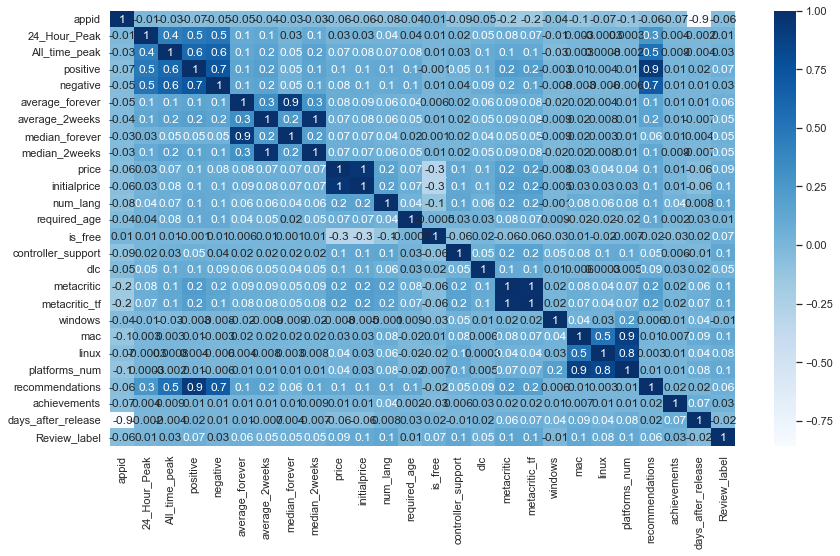

In [20]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = correlation.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

In [27]:
correlation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46252 entries, 0 to 46251
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   appid               46252 non-null  int64  
 1   24_Hour_Peak        46252 non-null  int32  
 2   All_time_peak       46252 non-null  int32  
 3   positive            46252 non-null  int64  
 4   negative            46252 non-null  int64  
 5   average_forever     46252 non-null  int64  
 6   average_2weeks      46252 non-null  int64  
 7   median_forever      46252 non-null  int64  
 8   median_2weeks       46252 non-null  int64  
 9   price               46252 non-null  float64
 10  initialprice        46252 non-null  float64
 11  genre               46252 non-null  object 
 12  num_lang            46252 non-null  int64  
 13  required_age        46252 non-null  float64
 14  is_free             46252 non-null  int32  
 15  controller_support  46252 non-null  int64  
 16  dlc 

<AxesSubplot:xlabel='Review_label', ylabel='num_lang'>

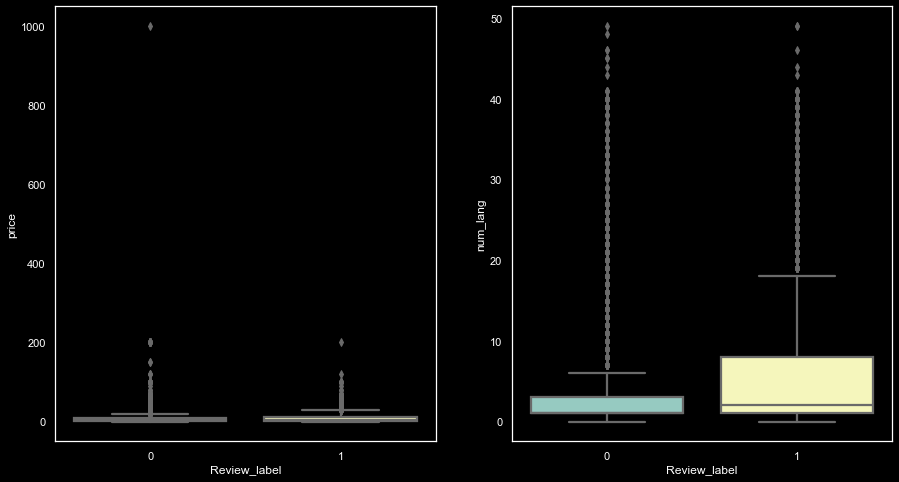

In [34]:
col_lst=correlation.columns
f,axes=plt.subplots(ncols=2,figsize=(15,8))
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
sns.boxplot(x="Review_label",y="price",data=correlation,ax=axes[0])

sns.boxplot(x="Review_label",y="num_lang",data=correlation,ax=axes[1])

<AxesSubplot:xlabel='Review_label', ylabel='dlc'>

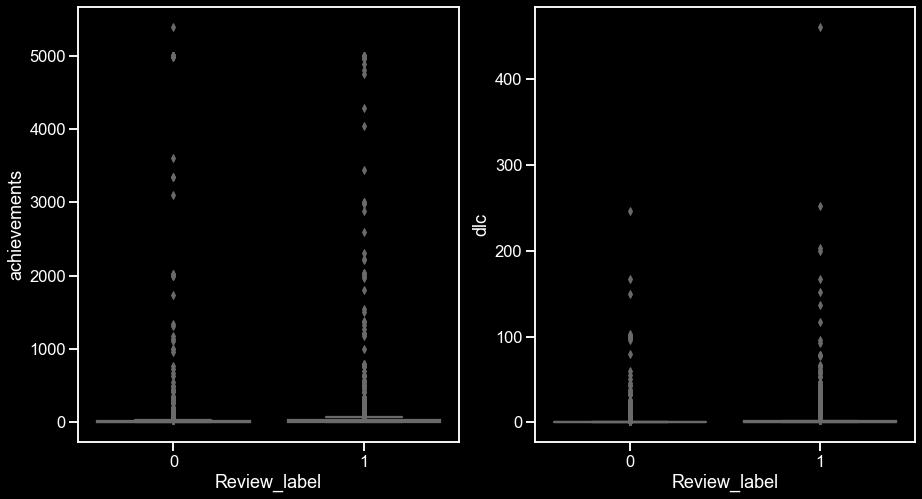

In [35]:
col_lst=correlation.columns
f,axes=plt.subplots(ncols=2,figsize=(15,8))
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
sns.boxplot(x="Review_label",y="achievements",data=correlation,ax=axes[0])

sns.boxplot(x="Review_label",y="dlc",data=correlation,ax=axes[1])

<AxesSubplot:xlabel='Review_label', ylabel='All_time_peak'>

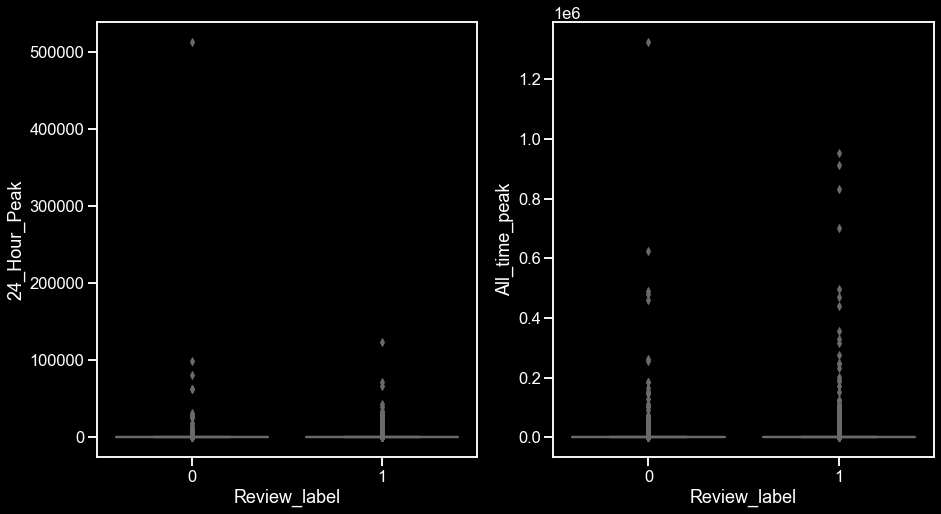

In [36]:
col_lst=correlation.columns
f,axes=plt.subplots(ncols=2,figsize=(15,8))
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
sns.boxplot(x="Review_label",y="24_Hour_Peak",data=correlation,ax=axes[0])

sns.boxplot(x="Review_label",y="All_time_peak",data=correlation,ax=axes[1])

In [95]:
def remove_outlier_test(d_cp,column):
    steam_data=d_cp[d_cp["Review_label"]==1][column]
    quan_25=np.percentile(steam_data.values,25)
    quan_75=np.percentile(steam_data.values,75)
    
    iqr=quan_75-quan_25
    iqr=iqr*1.5
    lowest=quan_25-iqr
    highest=quan_75+iqr
    outlier_index=steam_data[(steam_data<lowest)|(steam_data>highest)].index
    print(len(outlier_index))
    d_cp.drop(outlier_index,axis=0,inplace=True)
    print(d_cp.shape)
    return d_cp

In [96]:
data_copy=correlation.copy()

In [97]:
data_copy=remove_outlier_test(data_copy,"num_lang")

1690
(44562, 29)


In [98]:
correlation.shape

(46252, 29)

In [49]:
# price / dlc
print(max(correlation.dlc.values))
# df.drop(df[(df['Unit_Price'] >400) & (df['Unit_Price'] < 600)].index, inplace=True)
dlc_tmp=correlation.drop(correlation[(correlation.dlc==461.0)].index)

461.0


In [45]:
max(price_tmp.price.values)

199.99

In [51]:
max(dlc_tmp.dlc.values)

252.0

ValueError: Could not interpret input 'achievement'

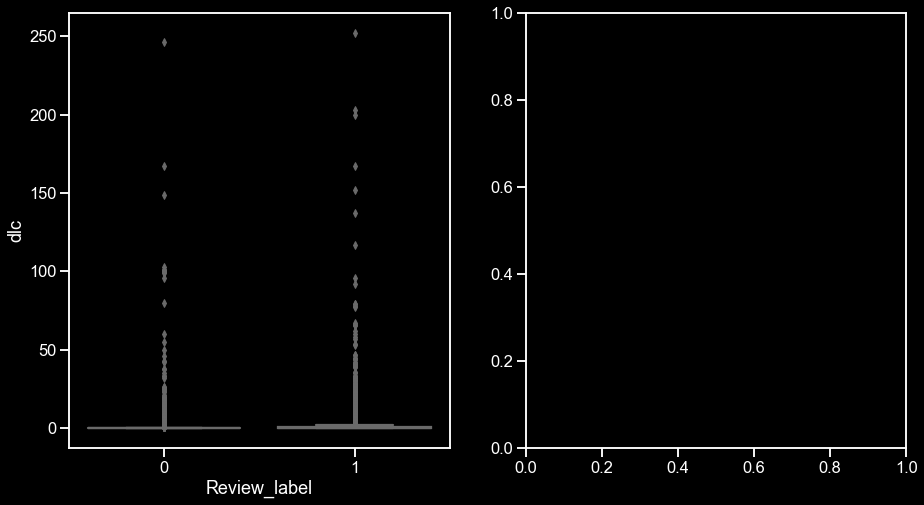

In [52]:
col_lst=correlation.columns
f,axes=plt.subplots(ncols=2,figsize=(15,8))
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
sns.boxplot(x="Review_label",y="dlc",data=dlc_tmp,ax=axes[0])

sns.boxplot(x="Review_label",y="achievement",data=dlc_tmp,ax=axes[1])

In [99]:
le=preprocessing.LabelEncoder()
le.fit(np.array(data_copy.Review))
y_true=le.fit_transform(data_copy.Review)
print(le.classes_)

['Negative' 'Positive']


In [100]:
data_copy=data_copy.drop(columns=["Review","Review_label"])

In [101]:
data_copy.shape

(44562, 27)

In [102]:
y_true.shape

(44562,)

In [103]:
data_copy=data_copy.drop(columns=["appid","positive","negative","genre","recommendations","new_date"])

In [76]:
x_train, x_val, y_train, y_val = train_test_split(
    data_copy,    # 문제 --> train/val
    y_true,    # 정답지
    test_size= 0.2, # train 데이터 중에서 20프로만 중간 검사용으로 빼두자..
    random_state= 1234, # 옵션 : 나중에 재현성을 위해서 seed값.
    stratify = y_true # 옵션 : 나눌 때 비율을 유지할지 말지....
)
kfold = KFold( n_splits=5, random_state=1234, shuffle=True)
# cv = 5 ---> 내가 run할 때 마다 셋들이 5개이기는 하지만 구성이 제각가..
# cv = kold ---> 언제, 어디서 하더라도 5개 셋이, 다 고정으로 동일하게 적용!!!
# 1) 모델
rf = RandomForestClassifier(n_jobs=-1, random_state=1234,verbose=2)
# 2) 파라미터의 조합 RGS --> 여러개가 있지만,,대표적인 것만 세팅..
parameters = {
    # 몇 개의 모델을 활용할지 
    "n_estimators" : [10, 100, 500, 1000], # 7
    # 세로에 대해서 어떻게 샘플링을 할지.
    "max_features" : ["sqrt","log2", None], # 3
    "min_samples_split" : [2, 5, 10],
    # 각 모델이 dt의 overfit을 조절하기
    "max_depth" : [2,5,10,20,100], # 10
    # min sample leaf
    "min_samples_leaf" : [1, 2, 4],
    "criterion" : ["gini", "entropy", "log_loss"],
    # 기타 여러 parameters 세팅 가능함....
}
# 3) RGS --> 몇 번 반복할지 
n_iter = 100
# 4) RGSCV 세팅.
rf_outlier = RandomizedSearchCV( rf, 
                                  param_distributions= parameters,
                                  cv = kfold,
                                  scoring = "accuracy",
                                  n_jobs= -1,
                                  random_state=1234,
                                  n_iter = n_iter,verbose=3
                                  )
# 5) 학습
rf_outlier.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000building tree 6 of 1000
building tree 7 of 1000

building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000building tree 12 of 1000
building tree 13 of 1000

building tree 14 of 1000building tree 15 of 1000

building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000building tree 19 of 1000

building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000building tree 23 of 1000

building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.2s


building tree 47 of 1000
building tree 48 of 1000
building tree 49 of 1000
building tree 50 of 1000
building tree 51 of 1000
building tree 52 of 1000
building tree 53 of 1000
building tree 54 of 1000
building tree 55 of 1000
building tree 56 of 1000
building tree 57 of 1000
building tree 58 of 1000
building tree 59 of 1000
building tree 60 of 1000
building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 67 of 1000
building tree 68 of 1000
building tree 69 of 1000
building tree 70 of 1000
building tree 71 of 1000
building tree 72 of 1000
building tree 73 of 1000
building tree 74 of 1000
building tree 75 of 1000
building tree 76 of 1000
building tree 77 of 1000building tree 78 of 1000building tree 79 of 1000


building tree 80 of 1000
building tree 81 of 1000
building tree 82 of 1000
building tree 83 of 1000
building tree 84 of 1000
building tree 85 of 1000
building tree 86 of 1000


[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.2s



building tree 161 of 1000
building tree 162 of 1000
building tree 163 of 1000
building tree 164 of 1000
building tree 165 of 1000building tree 166 of 1000

building tree 167 of 1000
building tree 168 of 1000
building tree 169 of 1000
building tree 170 of 1000
building tree 171 of 1000
building tree 172 of 1000building tree 173 of 1000
building tree 174 of 1000

building tree 175 of 1000building tree 176 of 1000

building tree 177 of 1000
building tree 178 of 1000
building tree 179 of 1000building tree 180 of 1000

building tree 181 of 1000
building tree 182 of 1000
building tree 183 of 1000
building tree 184 of 1000building tree 185 of 1000

building tree 186 of 1000
building tree 187 of 1000
building tree 188 of 1000
building tree 189 of 1000
building tree 190 of 1000
building tree 191 of 1000
building tree 192 of 1000
building tree 193 of 1000
building tree 194 of 1000
building tree 195 of 1000building tree 196 of 1000

building tree 197 of 1000
building tree 198 of 1000
building tr

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    2.9s



building tree 368 of 1000
building tree 369 of 1000
building tree 370 of 1000
building tree 371 of 1000
building tree 372 of 1000
building tree 373 of 1000
building tree 374 of 1000
building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000
building tree 379 of 1000
building tree 380 of 1000
building tree 381 of 1000
building tree 382 of 1000building tree 383 of 1000

building tree 384 of 1000
building tree 385 of 1000
building tree 386 of 1000
building tree 387 of 1000
building tree 388 of 1000
building tree 389 of 1000
building tree 390 of 1000
building tree 391 of 1000
building tree 392 of 1000
building tree 393 of 1000
building tree 394 of 1000
building tree 395 of 1000
building tree 396 of 1000
building tree 397 of 1000
building tree 398 of 1000
building tree 399 of 1000
building tree 400 of 1000
building tree 401 of 1000
building tree 402 of 1000
building tree 403 of 1000
building tree 404 of 1000
building tree 405 of 1000
building tr

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:    5.3s


building tree 662 of 1000

building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000building tree 673 of 1000
building tree 674 of 1000

building tree 675 of 1000
building tree 676 of 1000building tree 677 of 1000

building tree 678 of 1000
building tree 679 of 1000
building tree 680 of 1000
building tree 681 of 1000
building tree 682 of 1000building tree 683 of 1000

building tree 684 of 1000building tree 685 of 1000

building tree 686 of 1000
building tree 687 of 1000
building tree 688 of 1000
building tree 689 of 1000
building tree 690 of 1000
building tree 691 of 1000
building tree 692 of 1000
building tree 693 of 1000building tree 694 of 1000

building tree 695 of 1000
building tree 696 of 1000
building tree 697 of 1000
building tree 698 of 1000
building tree 699 of 1000
building tr

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    8.4s finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
                   estimator=RandomForestClassifier(n_jobs=-1,
                                                    random_state=1234,
                                                    verbose=2),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [2, 5, 10, 20, 100],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 100, 500, 1000]},
                   random_state=1234, scoring='accuracy', verbose=3)

In [77]:
rf_outlier.best_score_

0.7636627368632095

In [78]:
y_pred_val = rf_outlier.best_estimator_.predict(x_val)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.4s finished


In [79]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.73      0.89      0.80      4547
           1       0.82      0.61      0.70      3884

    accuracy                           0.76      8431
   macro avg       0.77      0.75      0.75      8431
weighted avg       0.77      0.76      0.75      8431



In [91]:
x_train, x_val, y_train, y_val = train_test_split(
    data_copy,    # 문제 --> train/val
    y_true,    # 정답지
    test_size= 0.2, # train 데이터 중에서 20프로만 중간 검사용으로 빼두자..
    random_state= 1234, # 옵션 : 나중에 재현성을 위해서 seed값.
    stratify = y_true # 옵션 : 나눌 때 비율을 유지할지 말지....
)
kfold = KFold( n_splits=5, random_state=1234, shuffle=True)
# cv = 5 ---> 내가 run할 때 마다 셋들이 5개이기는 하지만 구성이 제각가..
# cv = kold ---> 언제, 어디서 하더라도 5개 셋이, 다 고정으로 동일하게 적용!!!
# 1) 모델
rf = RandomForestClassifier(n_jobs=-1, random_state=1234,verbose=2)
# 2) 파라미터의 조합 RGS --> 여러개가 있지만,,대표적인 것만 세팅..
parameters = {
    # 몇 개의 모델을 활용할지 
    "n_estimators" : [10, 100, 500, 1000], # 7
    # 세로에 대해서 어떻게 샘플링을 할지.
    "max_features" : ["sqrt","log2", None], # 3
    "min_samples_split" : [2, 5, 10],
    # 각 모델이 dt의 overfit을 조절하기
    "max_depth" : [2,5,10,20,100], # 10
    # min sample leaf
    "min_samples_leaf" : [1, 2, 4],
    "criterion" : ["gini", "entropy", "log_loss"],
    # 기타 여러 parameters 세팅 가능함....
}
# 3) RGS --> 몇 번 반복할지 
n_iter = 100
# 4) RGSCV 세팅.
rf_outlier = RandomizedSearchCV( rf, 
                                  param_distributions= parameters,
                                  cv = kfold,
                                  scoring = "accuracy",
                                  n_jobs= -1,
                                  random_state=1234,
                                  n_iter = n_iter,verbose=3
                                  )
# 5) 학습
rf_outlier.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100
building tree 4 of 100

building tree 5 of 100
building tree 6 of 100

building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.3s


building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100building tree 48 of 100

building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100building tree 68 of 100

building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
                   estimator=RandomForestClassifier(n_jobs=-1,
                                                    random_state=1234,
                                                    verbose=2),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [2, 5, 10, 20, 100],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 100, 500, 1000]},
                   random_state=1234, scoring='accuracy', verbose=3)

In [92]:
rf_outlier.best_score_

0.7535758430216262

In [93]:
y_pred_val = rf_outlier.best_estimator_.predict(x_val)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [94]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.73      0.88      0.80      4547
           1       0.79      0.59      0.67      3546

    accuracy                           0.75      8093
   macro avg       0.76      0.73      0.74      8093
weighted avg       0.76      0.75      0.74      8093



In [104]:
x_train, x_val, y_train, y_val = train_test_split(
    data_copy,    # 문제 --> train/val
    y_true,    # 정답지
    test_size= 0.2, # train 데이터 중에서 20프로만 중간 검사용으로 빼두자..
    random_state= 1234, # 옵션 : 나중에 재현성을 위해서 seed값.
    stratify = y_true # 옵션 : 나눌 때 비율을 유지할지 말지....
)
kfold = KFold( n_splits=5, random_state=1234, shuffle=True)
# cv = 5 ---> 내가 run할 때 마다 셋들이 5개이기는 하지만 구성이 제각가..
# cv = kold ---> 언제, 어디서 하더라도 5개 셋이, 다 고정으로 동일하게 적용!!!
# 1) 모델
rf = RandomForestClassifier(n_jobs=-1, random_state=1234,verbose=2)
# 2) 파라미터의 조합 RGS --> 여러개가 있지만,,대표적인 것만 세팅..
parameters = {
    # 몇 개의 모델을 활용할지 
    "n_estimators" : [10, 100, 500, 1000], # 7
    # 세로에 대해서 어떻게 샘플링을 할지.
    "max_features" : ["sqrt","log2", None], # 3
    "min_samples_split" : [2, 5, 10],
    # 각 모델이 dt의 overfit을 조절하기
    "max_depth" : [2,5,10,20,100], # 10
    # min sample leaf
    "min_samples_leaf" : [1, 2, 4],
    "criterion" : ["gini", "entropy", "log_loss"],
    # 기타 여러 parameters 세팅 가능함....
}
# 3) RGS --> 몇 번 반복할지 
n_iter = 100
# 4) RGSCV 세팅.
rf_outlier = RandomizedSearchCV( rf, 
                                  param_distributions= parameters,
                                  cv = kfold,
                                  scoring = "accuracy",
                                  n_jobs= -1,
                                  random_state=1234,
                                  n_iter = n_iter,verbose=3
                                  )
# 5) 학습
rf_outlier.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 500building tree 2 of 500

building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500building tree 12 of 500

building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500building tree 18 of 500

building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500building tree 23 of 500

building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500building tree 35 of 500



[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.3s


building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500building tree 43 of 500

building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.6s



building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    3.8s


building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500building tree 372 of 500

building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500building tree 397 of 500

building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.4s finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
                   estimator=RandomForestClassifier(n_jobs=-1,
                                                    random_state=1234,
                                                    verbose=2),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [2, 5, 10, 20, 100],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 100, 500, 1000]},
                   random_state=1234, scoring='accuracy', verbose=3)

In [105]:
rf_outlier.best_score_

0.7278464765825223

In [106]:
y_pred_val = rf_outlier.best_estimator_.predict(x_val)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.5s finished


In [107]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.73      0.88      0.80      5367
           1       0.74      0.52      0.61      3546

    accuracy                           0.73      8913
   macro avg       0.74      0.70      0.70      8913
weighted avg       0.74      0.73      0.72      8913

